## Optimizing a Cycle Rep
We know our python implementation of an optimized bounding chain is more versatile (and maybe faster, idk yet) than the default OAT one. Here, we attempt to do the same thing for the cycle rep problem to see if we can get something (that may or may not be better).

### Preliminaries

In [1]:
# load some packages
import Gavin.utils.make_network as mn
import matplotlib.pyplot as plt
from scipy import sparse
import gurobipy as gb
from time import time
import pandas as pd
import oatpy as oat
import numpy as np

# config
DATA_PATH = 'datasets/concept_network/'
# CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics
# CONCEPT_FILE = 'concepts_Applied Economics_1402.csv.gz' # Applied Econ
CONCEPT_FILE = 'concepts_Zoology_608.csv' # Zoology
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MIN_FREQ = 0.0006
MAX_FREQ = 0.005

### Setup
Create the graph and solve for the network's homology. This, especially the `factored` object, will be used a lot in the optimization problem.

In [2]:
## Setup the graph
G = mn.gen_concept_network(
        DATA_PATH+CONCEPT_FILE,
        min_relevance=MIN_RELEVANCE,
        min_year=MIN_YEAR,
        min_articles=MIN_FREQ, # 0.006%
        max_articles=MAX_FREQ, # 0.05%
        normalize_year=True
    ) # use a filtered data file
adj = mn.adj_matrix(
        G,
        'norm_year',
        True,
        None
    )

In [3]:
## Solve homology
start = time()
# setup the problem
factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
        dissimilarity_matrix=adj,
        homology_dimension_max=2
    )
# solve homology
homology = factored.homology( # solve homology
        return_cycle_representatives=True, # These need to be true to be able to make a barcode, makes the problem take ~30% longer (1:30ish)
        return_bounding_chains=True
    )
f'Homology calculation took {time() - start} secs'

'Homology calculation took 0.6946680545806885 secs'

### Optimize the Cycle Rep

#### The LP
We'll use an LP to solve the problem. To optimize a $k$ dimensional cycle, we'll solve
\begin{align*}
    \min_{\mathbf{x}, \mathbf{q}, \mathbf{p}} \quad & \mathbf{c}^\top |\mathbf{x}| \\
    \text{subject to} \quad & \mathbf{x} = \mathbf{r} + \mathbf{\partial}_b \mathbf{q} + \mathbf{A}_b \mathbf{p}
\end{align*}
where $\mathbf{c}$ is some vector weights, $\mathbf{x}$ are the simplex coefficients in the optimal cycle, $\mathbf{r}$ is the initial, unoptimized representative cycle, $b$ is the birth time, $\mathbf{\partial}_b$ is the matrix that maps $k+1$ dimensional simplicies to their $k$ dimensional simplex boundary at filtration value $b$, and $\mathbf{A}_b$ is the cycle basis that maps cycles to the simpliccies that make them up at filtration value $b$.

#### Needed Values
To solve this LP, we'll need the death time of the cycle, the cycle itself (which we found earlier in the homology matrix), the boundary matrix indices, the boundary matrix, and the cycle basis (which we found earlier in the homology matrix). Alternatively, we could use the `factores.jordan_basis_vector` function for all of them, but I don't think this is faster without the whole Jordan basis already.

In [10]:
homology[homology['dimension'] == 1]

,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz
id,,,,,,,,,
226,1,1.000000,inf,"[259, 292]",None,simplex filtration coefficient 0 [25...,11,None,NaN
227,1,1.000000,inf,"[238, 280]",None,"simplex filtration coefficient 0 [238,...",9,None,NaN
228,1,1.000000,inf,"[111, 200]",None,simplex filtration coefficient 0 [11...,24,None,NaN
229,1,1.000000,inf,"[83, 219]",None,simplex filtration coefficient 0 [8...,12,None,NaN
230,1,1.000000,inf,"[26, 123]",None,"simplex filtration coefficient 0 [26,...",6,None,NaN
...,...,...,...,...,...,...,...,...,...
672,1,0.693069,0.980198,"[43, 184]","[55, 266, 287]","simplex filtration coefficient 0 [43,...",5,simplex filtration coefficient 0 ...,15.0
673,1,0.693069,0.782178,"[43, 170]","[86, 170, 225]","simplex filtration coefficient 0 [43,...",6,simplex filtration coefficient 0 [...,6.0
674,1,0.683168,0.811881,"[86, 183]","[227, 229, 232]",simplex filtration coefficient 0 [8...,12,simplex filtration coefficient 0 ...,16.0


In [12]:
# the cycle we solve for
cycle_i = 400

# info about it
cycle_dim = 1
birth = homology.loc[cycle_i, 'birth']
simplex_indicies = factored.indices_boundary_matrix()
boundry_matrix = factored.boundary_matrix().astype(float) # this includes everything, not just k+1 dim to k dim, we'll need to filter later
cycle = homology.loc[cycle_i, 'cycle representative']
cycle['coefficient'] = cycle['coefficient'].astype(float)
# scipy/gurobi likes floats more

#### The Cycle
The cycle doesn't include 0 coefficients. We'll map our cycle coefficients into just the dimension one simplicices in `simplex_indicies` set everything else to 0. This coefficeint column is $\mathbf{r}$ in the LP.

In [13]:
# get relevant simplicies
cycle_rep = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+1].reset_index() # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
cycle_rep = cycle_rep[cycle_rep['filtration'] <= birth] # only need ones that exist before the death time

# figure out coefficients
cycle_rep = cycle_rep.assign(
        simplex=cycle_rep['simplex'].apply(tuple) # can't merge on lists, convert to tuples first (which is hashable)
    ).merge(
        right=cycle.assign(
                simplex=cycle['simplex'].apply(tuple) # same list merge issue
            ),
        on=['simplex', 'filtration'],
        how='left' # keep cycle rep list as is, just with coefificeint column
    ).assign(
        simplex=cycle_rep['simplex'].apply(list) # convert back to list (prolly doesn't need to done done but still)
    ).replace(
        np.nan, 0 # set unmerged columns to 0
    )

cycle_rep

,index,simplex,filtration,coefficient
0,302,"[16, 24]",0.039604,0.0
1,303,"[22, 33]",0.069307,0.0
2,304,"[7, 33]",0.079208,0.0
3,305,"[86, 225]",0.099010,0.0
4,306,"[86, 234]",0.099010,0.0
...,...,...,...,...
1386,1688,"[261, 295]",0.910891,0.0
1387,1689,"[277, 282]",0.910891,0.0
1388,1690,"[277, 294]",0.910891,0.0
1389,1691,"[282, 294]",0.910891,0.0


#### The Boundary Matrix
Use the `boundry_matrix` and at the indicies in the `cycle_rep` and `bounding_chain` dataframes to create $\mathbf{\partial}_d$ from the LP. We keep rows corresponding to the `cycle_rep` values (since the rows should map to the cycle coefficients) and the columns from `bounding_chain` (since the columns should each multiply by the bounding chain coefficients).

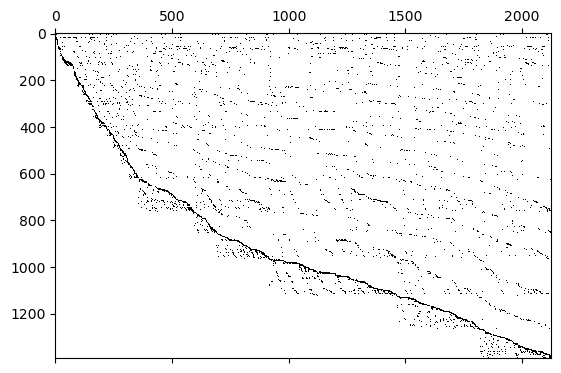

In [14]:
# get relevant simplicies
higher_dim_simplcicies = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+2].reset_index() # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
higher_dim_simplcicies = higher_dim_simplcicies[higher_dim_simplcicies['filtration'] <= birth] # only need ones that exist before the death time

'''
Scipy matricies are werid. Something like 
```
lp_boundry_matrix = boundry_matrix[cycle_rep['index'], higher_dim_simplcicies['index']]
```
should work, but it doesn't support real indexing without either a slice for the other one or both being the same length

Therfore, you either do something like this
```
# spare matricies are really finicky and don't have great support for index referenceing. therefore, we find slice indicies and use that
cycle_min_i = cycle_rep['index'].min()
cycle_max_i = cycle_rep['index'].max()+1 # upper bound is exclusive
assert (cycle_rep['index'] == np.arange(cycle_min_i, cycle_max_i)).all() # make sure index is a range (so slicing is valid)

higher_dim_simplcicies_min_i = higher_dim_simplcicies['index'].min()
higher_dim_simplcicies_max_i = higher_dim_simplcicies['index'].max()+1 # upper bound is exclusive
assert (higher_dim_simplcicies['index'] == np.arange(higher_dim_simplcicies_min_i, higher_dim_simplcicies_max_i)).all() # make sure index is a range (so slicing is valid)

# get bounding chain bounds
lp_boundry_matrix = boundry_matrix[cycle_min_i:cycle_max_i, higher_dim_simplcicies_min_i:higher_dim_simplcicies_max_i]
```
and use slicing or use the following implentation
'''
lp_boundry_matrix = boundry_matrix[cycle_rep['index'], :][:, higher_dim_simplcicies['index']]

plt.spy(lp_boundry_matrix, marker=',', c='k')

#### Cycle Basis
We need a basis for all of the cycles. To do that, we take all the cycles born before `birth` that we have cycle reps for in homology and create a cycle basis matrix with them

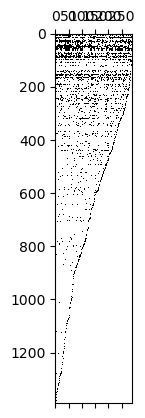

In [15]:
# cycles in the cycle basis
cycle_basis_cycles = homology[(homology['dimension'] == cycle_dim) # should have the same dimension as the cycle
                              & (homology['birth'] <= birth) # should be born before the cycle
                              & (homology.index != cycle_i)]['cycle representative'] # shouldn't be initial cycle

# matrix
cycle_basis = sparse.csc_matrix((len(cycle_rep), len(cycle_basis_cycles))) # create a cycle basis matrix
# matrix has # of simplicies cols and # of cycles rows
cycle_basis_i = pd.DataFrame(cycle_rep['simplex'].map(tuple)).reset_index().set_index('simplex') # dataframe that maps simplex (tuples) to their index

# fill in matrix
for i, c in enumerate(cycle_basis_cycles):
    cycle_is = cycle_basis_i.loc[c['simplex'].map(tuple)]['index']
    cycle_basis[cycle_is, i] = c['coefficient']

plt.spy(cycle_basis, marker=',', c='k')

#### Solve the Model
Use the Gurobipy bindings to solve the model.

In [16]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
pos_coeffs = m.addMVar((len(cycle_rep)), name='pos_coeffs')
neg_coeffs = m.addMVar((len(cycle_rep)), name='neg_coeffs')
boundries = m.addMVar((lp_boundry_matrix.shape[1]), lb=-gb.GRB.INFINITY, name='boundries')
cycles = m.addMVar((cycle_basis.shape[1]), lb=-gb.GRB.INFINITY, name='cycles')

# constraints
m.addConstr(pos_coeffs-neg_coeffs == np.array(cycle_rep['coefficient']) + lp_boundry_matrix @ boundries + cycle_basis @ cycles, 'cycle') # idk if pandas works with gurobi, im not thinking about it rn tho

# objective
m.setObjective(gb.quicksum(np.array(cycle_rep['filtration']) * (pos_coeffs+neg_coeffs)))

# optimize
m.optimize()

# get solution
cycle_rep['optimized coefficient'] = pos_coeffs.X - neg_coeffs.X

# close model
m.close()

# clean results
optimal_cycle_rep = cycle_rep.loc[cycle_rep['optimized coefficient'] != 0, ['simplex', 'filtration', 'optimized coefficient']].reset_index(drop=True)

optimal_cycle_rep

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2531206
Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 1391 rows, 5195 columns and 12165 nonzeros
Model fingerprint: 0xedd70eeb
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [4e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 792 rows and 1274 columns
Presolve time: 0.01s
Presolved: 599 rows, 3921 columns, 12147 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     324    3.3861386e+00   0.000000e+00   0.000000e+00      0s

Solved in 324 iterations and 0.06 sec

,simplex,filtration,optimized coefficient
0,"[99, 181]",0.742574,-1.0
1,"[177, 267]",0.831683,-1.0
2,"[177, 181]",0.900990,1.0
3,"[99, 267]",0.910891,1.0


In [86]:
death = homology.loc[cycle_i, 'death']

In [87]:
# bounding chain
# get relevant simplicies
bounding_chain = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+2] # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
bounding_chain = bounding_chain[bounding_chain['filtration'] <= death] # only need ones that exist before the death time

bounding_chain

,simplex,filtration
3098,"[86, 225, 234]",0.099010
3099,"[7, 16, 24]",0.108911
3100,"[7, 22, 33]",0.178218
3101,"[170, 226, 229]",0.485149
3102,"[161, 225, 233]",0.514851
...,...,...
10514,"[277, 282, 298]",0.990099
10515,"[277, 294, 298]",0.990099
10516,"[277, 297, 298]",0.990099
10517,"[282, 294, 301]",0.990099


In [88]:
# get relevant simplicies
cycle_rep = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+1] # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
cycle_rep = cycle_rep[cycle_rep['filtration'] <= death] # only need ones that exist before the death time

cycle_rep

,simplex,filtration
302,"[16, 24]",0.039604
303,"[22, 33]",0.069307
304,"[7, 33]",0.079208
305,"[86, 225]",0.099010
306,"[86, 234]",0.099010
...,...,...
2967,"[262, 279]",0.990099
2968,"[268, 287]",0.990099
2969,"[276, 282]",0.990099
2970,"[277, 298]",0.990099


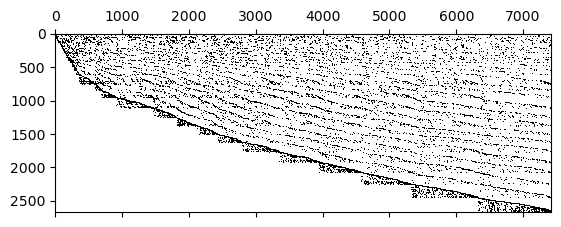

In [89]:
boundry_matrix = factored.boundary_matrix().astype(float)
boundry_matrix = boundry_matrix[cycle_rep.index, :][:, bounding_chain.index]

cycle_rep = cycle_rep.reset_index(drop=True)
bounding_chain = bounding_chain.reset_index(drop=True)

plt.spy(boundry_matrix, marker=',', c='k')

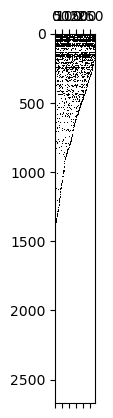

In [90]:
# cycles in the cycle basis
cycle_basis_cycles = homology[(homology['dimension'] == cycle_dim) # should have the same dimension as the cycle
                              & (homology['birth'] <= birth) # should be born before the cycle
                              & (homology.index != cycle_i)]['cycle representative'] # shouldn't be initial cycle

# matrix
cycle_basis = sparse.csc_matrix((len(cycle_rep), len(cycle_basis_cycles))) # create a cycle basis matrix
# matrix has # of simplicies cols and # of cycles rows
cycle_basis_i = pd.DataFrame(cycle_rep['simplex'].map(tuple)).reset_index().set_index('simplex') # dataframe that maps simplex (tuples) to their index

# fill in matrix
for i, c in enumerate(cycle_basis_cycles):
    cycle_is = cycle_basis_i.loc[c['simplex'].map(tuple)]['index']
    cycle_basis[cycle_is, i] = c['coefficient']

plt.spy(cycle_basis, marker=',', c='k')

In [91]:
# figure out coefficients
cycle_rep = cycle_rep.assign(
        simplex=cycle_rep['simplex'].apply(tuple) # can't merge on lists, convert to tuples first (which is hashable)
    ).merge(
        right=cycle.assign(
                simplex=cycle['simplex'].apply(tuple) # same list merge issue
            ),
        on=['simplex', 'filtration'],
        how='left' # keep cycle rep list as is, just with coefificeint column
    ).assign(
        simplex=cycle_rep['simplex'].apply(list) # convert back to list (prolly doesn't need to done done but still)
    ).replace(
        np.nan, 0 # set unmerged columns to 0
    )

cycle_rep

,simplex,filtration,coefficient
0,"[16, 24]",0.039604,0.0
1,"[22, 33]",0.069307,0.0
2,"[7, 33]",0.079208,0.0
3,"[86, 225]",0.099010,0.0
4,"[86, 234]",0.099010,0.0
...,...,...,...
2665,"[262, 279]",0.990099,0.0
2666,"[268, 287]",0.990099,0.0
2667,"[276, 282]",0.990099,0.0
2668,"[277, 298]",0.990099,0.0


In [95]:
bounding_chain[bounding_chain['filtration'] <= birth]

,simplex,filtration
0,"[86, 225, 234]",0.099010
1,"[7, 16, 24]",0.108911
2,"[7, 22, 33]",0.178218
3,"[170, 226, 229]",0.485149
4,"[161, 225, 233]",0.514851
...,...,...
2120,"[245, 297, 301]",0.910891
2121,"[260, 277, 282]",0.910891
2122,"[260, 277, 294]",0.910891
2123,"[260, 282, 294]",0.910891


In [115]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
cycle_coefs = m.addMVar((len(cycle_rep)), lb=-gb.GRB.INFINITY, name='cycle_coeffs')
pos_bc_coeffs = m.addMVar((len(bounding_chain)), name='pos_bc_coeffs')
neg_bc_coeffs = m.addMVar((len(bounding_chain)), name='neg_bc_coeffs')
boundries = m.addMVar(len(bounding_chain[bounding_chain['filtration'] <= birth]), lb=-gb.GRB.INFINITY, name='boundries')
cycles = m.addMVar((cycle_basis.shape[1]), lb=-gb.GRB.INFINITY, name='cycles')

# constraints
m.addConstr(cycle_coefs == np.array(cycle_rep['coefficient']) + boundry_matrix[:, bounding_chain[bounding_chain['filtration'] <= birth].index] @ boundries + cycle_basis @ cycles, 'cycle') # idk if pandas works with gurobi, im not thinking about it rn tho
m.addConstr(cycle_coefs == boundry_matrix @ (pos_bc_coeffs-neg_bc_coeffs))

# objective
m.setObjective(gb.quicksum(np.array(bounding_chain['filtration']) * (pos_bc_coeffs+neg_bc_coeffs)))

# optimize
m.optimize()

# get solution
cycle_rep['coefficient'] = cycle_coefs.X
bounding_chain['coefficient'] = pos_bc_coeffs.X - neg_bc_coeffs.X

# close model
m.close()

# clean results
optimal_cycle_rep = cycle_rep.loc[cycle_rep['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)
optimal_bounding_chain = bounding_chain.loc[bounding_chain['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)

optimal_cycle_rep, optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 5340 rows, 19925 columns and 59249 nonzeros
Model fingerprint: 0xfa028352
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3753 rows and 7212 columns
Presolve time: 0.05s
Presolved: 1587 rows, 12713 columns, 34160 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier performed 0 iterations in 0.07 seconds (0.06 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 9
Iteration    Objective       Pr

(      simplex  filtration  coefficient
 0  [100, 187]    0.613861          1.0
 1   [99, 187]    0.722772         -1.0
 2  [100, 177]    0.772277         -1.0
 3  [177, 267]    0.831683         -1.0
 4   [99, 267]    0.910891          1.0,
            simplex  filtration  coefficient
 0   [99, 187, 267]    0.940594         -1.0
 1  [100, 177, 187]    0.990099         -1.0
 2  [177, 187, 267]    0.990099          1.0)

### OAT Optimization
Use OAT to make an optimal cycle rep. Use this as a comparison with our results

In [17]:
# optimization problem
start = time()
optimal = factored.optimize_cycle(
        birth_simplex=homology.loc[cycle_i, 'birth simplex'],
        problem_type='preserve PH basis'
    )
print(f'Optimizaiton took {time() - start} secs')

# filter the cycle (only include good coeficicents)
dirty_optimal = optimal.loc['optimal cycle', 'chain'] # round all the dumb and bad coefficicents
dirty_optimal['coefficient'] = dirty_optimal['coefficient'].astype(float) # use floats to interact with gurobi
optimal_cycle = dirty_optimal[np.logical_not(np.isclose(dirty_optimal['coefficient'], 0, atol=0.1))]

# print the cycle
optimal_cycle

Set parameter WLSAccessID
Optimizaiton took 0.15561485290527344 secs
Set parameter WLSSecret
Set parameter LicenseID to value 2531206
Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 2594 rows, 2334 columns and 17542 nonzeros
Model fingerprint: 0x5e3daba7
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [4e-02, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2033 rows and 13 columns
Presolve time: 0.01s
Presolved: 561 rows, 2321 columns, 10440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                         

,simplex,filtration,coefficient
0,"[99, 267]",0.910891,1.0
1,"[177, 181]",0.900990,1.0
2,"[177, 267]",0.831683,-1.0
3,"[99, 181]",0.742574,-1.0
